In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import sys
import seaborn as sns
from pandas import DataFrame
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
mpl.rc('image', cmap='Pastel1')
np.random.seed(42)
import dill
import matplotlib.patches as mpatches
from sklearn.inspection import permutation_importance

In [2]:
dill.load_session('Method_eval_corr.db')

In [3]:
whole_df = pd.read_csv("/Users/jozef/Jupyter/Signal Processing/DBS/data/all_features.csv")

In [4]:
whole_df = whole_df[~(whole_df['session'] == 2)]

In [95]:
# find correlated features
# code based on https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection
drop = {}
for name, group in whole_df.groupby('session'):
    correlated_features = []
    features = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
    correlation_matrix = features.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.append(colname)
    drop[name] = correlated_features

(120, 22)
(156, 21)
(192, 25)
(175, 22)
(191, 26)


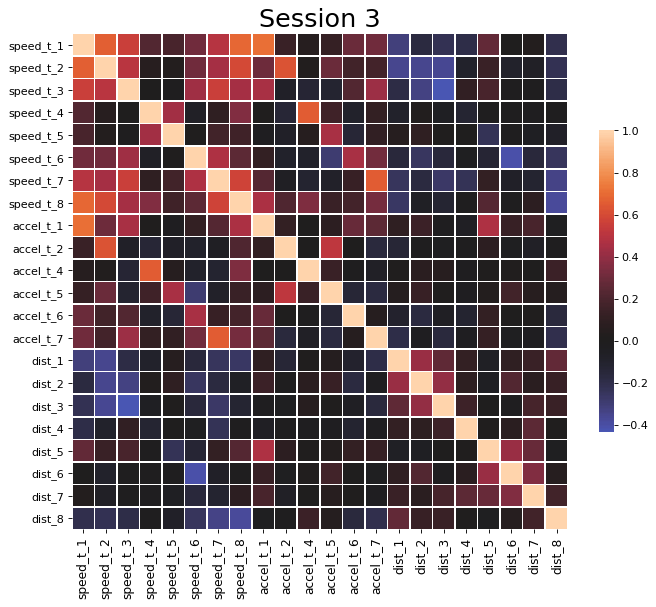

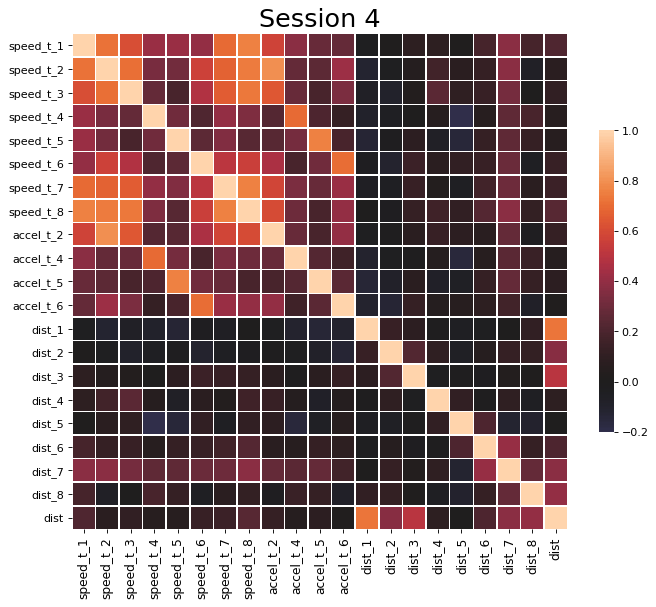

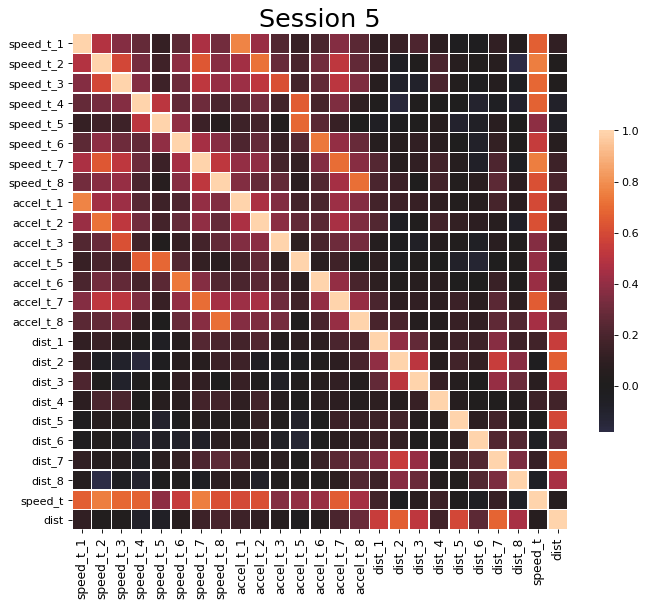

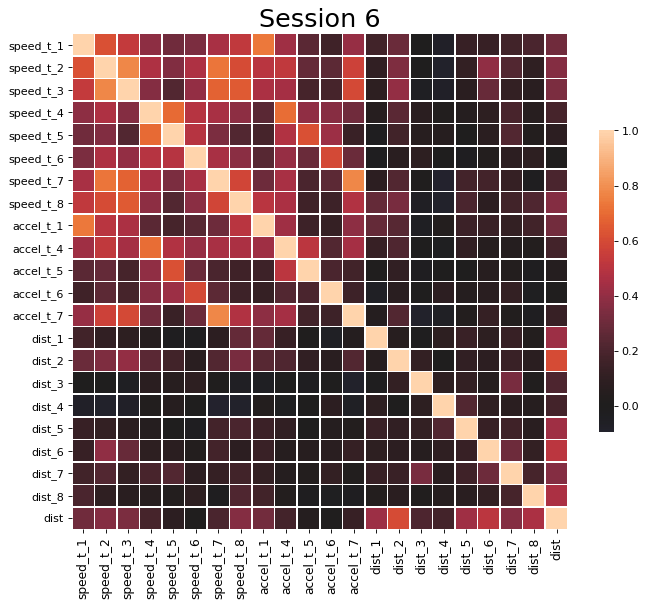

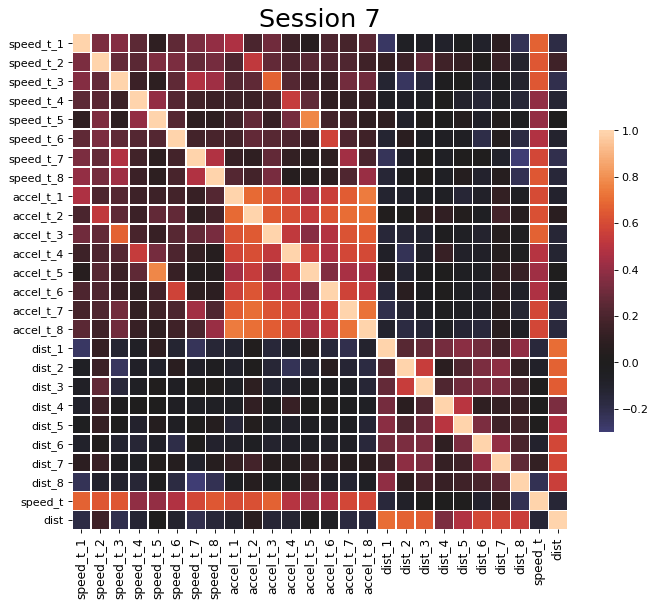

In [97]:
# plot correlation matrices with correlated features removed
for name, group in whole_df.groupby('session'):
    
    features = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'] 
                             + drop2[name], axis =1)
    print(features.shape)
    corr = features.corr()
    
    figure(figsize=(10, 10), dpi=80)
    sns.heatmap(corr, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Session " + str(name), fontsize = 23)
    plt.savefig("Session " + str(name) + " decorrelated correlation matrix ")
    

In [7]:
import random

class CustomSplitter():
    """
    Custom cross-validation splitter class.
    Splitter returns a test set of one DBS-on block and one DBS-off block.
    The rest of the blocks are used for the training data
    """
    def __init__(self):
        pass

    def split(self, X):
        """
        Split the data in train and test sets.
        
        @param X: pandas DataFrame containing at least the columns 'stim' and 'ix_block'
        @return splits: list of train, test index tuples
        """
        on_blocks = X[X['stim'] == 1]['ix_block'].unique()
        off_blocks = X[X['stim'] == 0]['ix_block'].unique()
        
        splits = []
        n_splits = min(len(on_blocks), len(off_blocks))
        
        for i in range(n_splits):            
            
            test_index = np.where(X['ix_block'] == on_blocks[i])
            test_index = np.append(test_index, np.where(X['ix_block'] == off_blocks[i]))
            
            train_index = [x for x in np.arange(len(X)) if x not in test_index]
            
            splits.append((train_index, test_index))
            
        return splits
        

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer

def hyperparam_opt(df, pipeline, params, drop ,transform = False):
    """
    Function that evaluates a method using a nested crossvalidation procedure in which the inner 
    loop performs a grid search over the specified hyperparameters

    @param df: pandas DataFrame containing the data
    @param pipeline: sklearn Pipeline containing the method
    @param params: dictionary of the hyperparameter ranges used in the grid search
    @param drop: dictionary containing the correlated features per session
    @param transform: boolean to control whether we use the transform function or predict_proba only 
    neccessary for the baseline LDA

    
    @return results: pandas DataFrame containing the scores generated by the validation procedure
    @return searches: dictionary containing the GridSearchCV classes of every fold. 
    """
    validation_scores = {}
    holdout_scores = {}
    best_params = {}
    searches = {}   
    
    for name, group in df.groupby('session'):
        print("\n------------------------------------------------------------------")
        print('Session %2d' % name)

        on_blocks = group[group['stim'] == 1]['ix_block'].unique()
        off_blocks = group[group['stim'] == 0]['ix_block'].unique()

        valid_holdout_count = min(len(on_blocks), len(off_blocks))

        holdout_scores[name] = []
        validation_scores[name] = []
        best_params[name] = []
        searches[name] = []
        
        print("testing %d rounds" %valid_holdout_count)

        for k in range(valid_holdout_count):
            holdout_blocks = [on_blocks[k], off_blocks[k]]

            holdout_data = group[group['ix_block'].isin(holdout_blocks)]
            holdout_X = holdout_data.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp']
                                          + drop[name], axis =1)
            holdout_y = holdout_data['stim']

            valid_data = group[~group['ix_block'].isin(holdout_blocks)]
            X = valid_data.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp']
                                + drop[name], axis =1)

            y = valid_data['stim']

            valid_data.reset_index(drop=True, inplace=True)

            kf = CustomSplitter()

            gscv = GridSearchCV(pipeline, params, cv = kf.split(valid_data), 
                                scoring = make_scorer(roc_auc_score, needs_proba=True), 
                                verbose = 1, n_jobs = -1)

            search = gscv.fit(X,y)       
            
            best_params[name].append(search.best_params_)
            validation_scores[name].append(search.best_score_)
            searches[name].append(search)
    
            
            if transform:
                if np.mean(search.transform(X[y==0])) > np.mean(search.transform(X[y==1])):          
                    holdout_scores[name].append(roc_auc_score((holdout_y  *-1) + 1, search.transform(holdout_X)))
                else:
                    holdout_scores[name].append(roc_auc_score(holdout_y, search.transform(holdout_X)))
            else:
                holdout_scores[name].append(roc_auc_score(holdout_y, search.predict_proba(holdout_X)[:,1] ))
            
            
            print(search.best_params_)

        print(validation_scores[name])
        print(holdout_scores[name])

    data = {'session': [], 'validation_scores': [], 'holdout_scores': [], 'best_params': []}
    
    for i in range(3,8):
        data['session'].append(i)
        data['validation_scores'].append(validation_scores[i])
        data['holdout_scores'].append(holdout_scores[i])    
        data['best_params'].append(best_params[i])
        
    results = pd.DataFrame(data)
    
    return results, searches

In [63]:
def get_best_params(searches):
    """
    Function that extracts the best performing hyperparameters per session
    
    @params searches: dictionary of lists of GridSearchCV classes
    
    @return best_params: dictionary of best parameters per session
    """
    best_params = {}
    
    for sesh in range(2,8):
        scores = np.ones_like(searches[sesh][0].cv_results_['mean_test_score'])
        for i in range(len(searches[sesh])):
            scores = scores + searches[sesh][i].cv_results_['mean_test_score']
        
        score_df = pd.DataFrame(data = {'params': searches[sesh][0].cv_results_['params'], 
                                        'scores': scores})
        
        max_score = max(score_df['scores'])
        
        best_params[sesh] = score_df[score_df['scores'] == max_score]['params'].iloc[0]
    return best_params

# Hyperparameter optimization

## standard data

In [65]:
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))])

params = {"classifier__C" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10], 
                   "classifier__gamma": [0.0001, 0.001, 0.01, 0.1, 1.0, 10]} 

standard_svc, standard_svc_searches = hyperparam_opt(whole_df, pipeline, params, drop)


------------------------------------------------------------------
Session  3
testing 5 rounds
Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.01}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.01}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
[0.8715277777777777, 0.8315972222222222, 0.892361111111111, 0.8732638888888888, 0.8784722222222222]
[0.8680555555555556, 1.0, 0.7986111111111112, 0.8194444444444443, 0.8472222222222222]

------------------------------------------------------------------
Session  4
testing 6 rounds
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [66]:
pipeline = Pipeline([('classifier', RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=128))])

params = {'classifier__criterion': ['gini', 'entropy'],
          'classifier__max_features': ['sqrt', 0.2, 0.3, 0.4, 0.8],
          'classifier__max_samples': [0.2, 0.4, 0.6, 0.8, None]
         }

standard_rf, standard_rf_searches = hyperparam_opt(whole_df, pipeline, params, drop)


------------------------------------------------------------------
Session  3
testing 5 rounds
Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.3, 'classifier__max_samples': 0.4}
Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.2}
Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.4}
Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.2}
Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.8, 'classifier__max_samples': 0.2}
[0.8229166666666666, 0.7803819444444444, 0.8845486111111112, 0.818576388888888

In [67]:
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', LDA())])

params = {"classifier__solver" : ['lsqr', 'eigen'], 
           "classifier__shrinkage": ['auto', None]} 

standard_lda, standard_lda_searches = hyperparam_opt(whole_df, pipeline, params, drop)


------------------------------------------------------------------
Session  3
testing 5 rounds
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
[0.8454861111111112, 0.7899305555555556, 0.8472222222222222, 0.8177083333333334, 0.8645833333333333]
[0.7986111111111112, 0.9722222222222222, 0.7847222222222222, 0.8472222222222222, 0.7777777777777779]

------------------------------------------------------------------
Session  4
tes

In [68]:
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LogisticRegression())])

params = [{"classifier__solver" : ['newton-cg'], 
           "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
         }]

standard_lr, standard_lr_searches = hyperparam_opt(whole_df, pipeline, params, drop)


------------------------------------------------------------------
Session  3
testing 5 rounds
Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'classifier__C': 0.01, 'classifier__solver': 'newton-cg'}
Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'classifier__C': 0.0001, 'classifier__solver': 'newton-cg'}
Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}
Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}
Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'classifier__C': 0.001, 'classifier__solver': 'newton-cg'}
[0.8454861111111112, 0.8003472222222223, 0.8472222222222222, 0.8246527777777778, 0.8576388888888888]
[0.8055555555555556, 0.9722222222222222, 0.7638888888888888, 0.8263888888888888, 0.7430555555555556]

------------------------------------------------------------------
Session  4
testing 6 rounds
Fitting 5 

In [69]:
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LDA())])

params = {"classifier__solver" : ['eigen'], 
           "classifier__shrinkage": ['auto']}

standard_lda_transform, standard_lda_transform_searches = hyperparam_opt(whole_df, pipeline, params, drop, transform = True)


------------------------------------------------------------------
Session  3
testing 5 rounds
Fitting 4 folds for each of 1 candidates, totalling 4 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 4 folds for each of 1 candidates, totalling 4 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 4 folds for each of 1 candidates, totalling 4 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 4 folds for each of 1 candidates, totalling 4 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 4 folds for each of 1 candidates, totalling 4 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
[0.8454861111111112, 0.7899305555555556, 0.8472222222222222, 0.8177083333333334, 0.8645833333333333]
[0.8194444444444445, 0.9722222222222223, 0.8125, 0.8402777777777778, 0.75]

------------------------------------------------------------------
Session  4
testing 6 rounds
Fitting 5 fo

In [71]:
data = {'session': [3,4,5,6,7], 
        'LDA': pd.DataFrame(standard_lda['holdout_scores'].values.tolist()).mean(1),
       'Logistic Regression': pd.DataFrame(standard_lr['holdout_scores'].values.tolist()).mean(1),
       'Random Forest': pd.DataFrame(standard_rf['holdout_scores'].values.tolist()).mean(1),
       'SVC': pd.DataFrame(standard_svc['holdout_scores'].values.tolist()).mean(1),
       'Baseline LDA': pd.DataFrame(standard_lda_transform['holdout_scores'].values.tolist()).mean(1)
       }

standard_holdout_results = pd.DataFrame(data)
standard_holdout_results

,session,LDA,Logistic Regression,Random Forest,SVC,Baseline LDA
0,3,0.836111,0.822222,0.817361,0.866667,0.838889
1,4,0.798611,0.781250,0.853588,0.756944,0.802083
2,5,0.870660,0.855903,0.852865,0.861111,0.874132
3,6,0.955087,0.939123,0.927895,0.952291,0.958153
4,7,0.702967,0.716935,0.656447,0.752210,0.539931


In [72]:
standard_holdout_results.mean()

session                5.000000
LDA                    0.832687
Logistic Regression    0.823087
Random Forest          0.821631
SVC                    0.837845
Baseline LDA           0.802638
dtype: float64

In [73]:
# load scores on original data-set
raw_standard_scores = pd.read_csv("data/raw_standard_scores.csv")

In [74]:
# aggregate data on decorrelated features
data = {
        'LDA': np.hstack(standard_lda['holdout_scores'].values.tolist()),
       'Logistic Regression': np.hstack(standard_lr['holdout_scores'].values.tolist()),
       'Random Forest': np.hstack(standard_rf['holdout_scores'].values.tolist()),
       'SVC': np.hstack(standard_svc['holdout_scores'].values.tolist()),
       'Baseline LDA': np.hstack(standard_lda_transform['holdout_scores'].values.tolist())
       }

raw_decorrelated_scores = pd.DataFrame(data)

In [4]:
from scipy.stats import wilcoxon
# Test whether removing correlated features improves performance significantly

full_dataset_scores = raw_standard_scores.to_numpy().flatten()
decorrelated_dataset_scores = raw_decorrelated_scores.to_numpy().flatten()
wilcoxon(decorrelated_dataset_scores, full_dataset_scores)

WilcoxonResult(statistic=4387.5, pvalue=0.012092084313654595)

In [5]:
# test whether removing correlated features significantly improves performance
lr_full_dataset_scores = raw_standard_scores['Logistic Regression']
lr_decorrelated_dataset_scores = raw_decorrelated_scores['Logistic Regression']
wilcoxon(lr_full_dataset_scores, lr_decorrelated_dataset_scores)

WilcoxonResult(statistic=196.5, pvalue=0.3126706207468921)

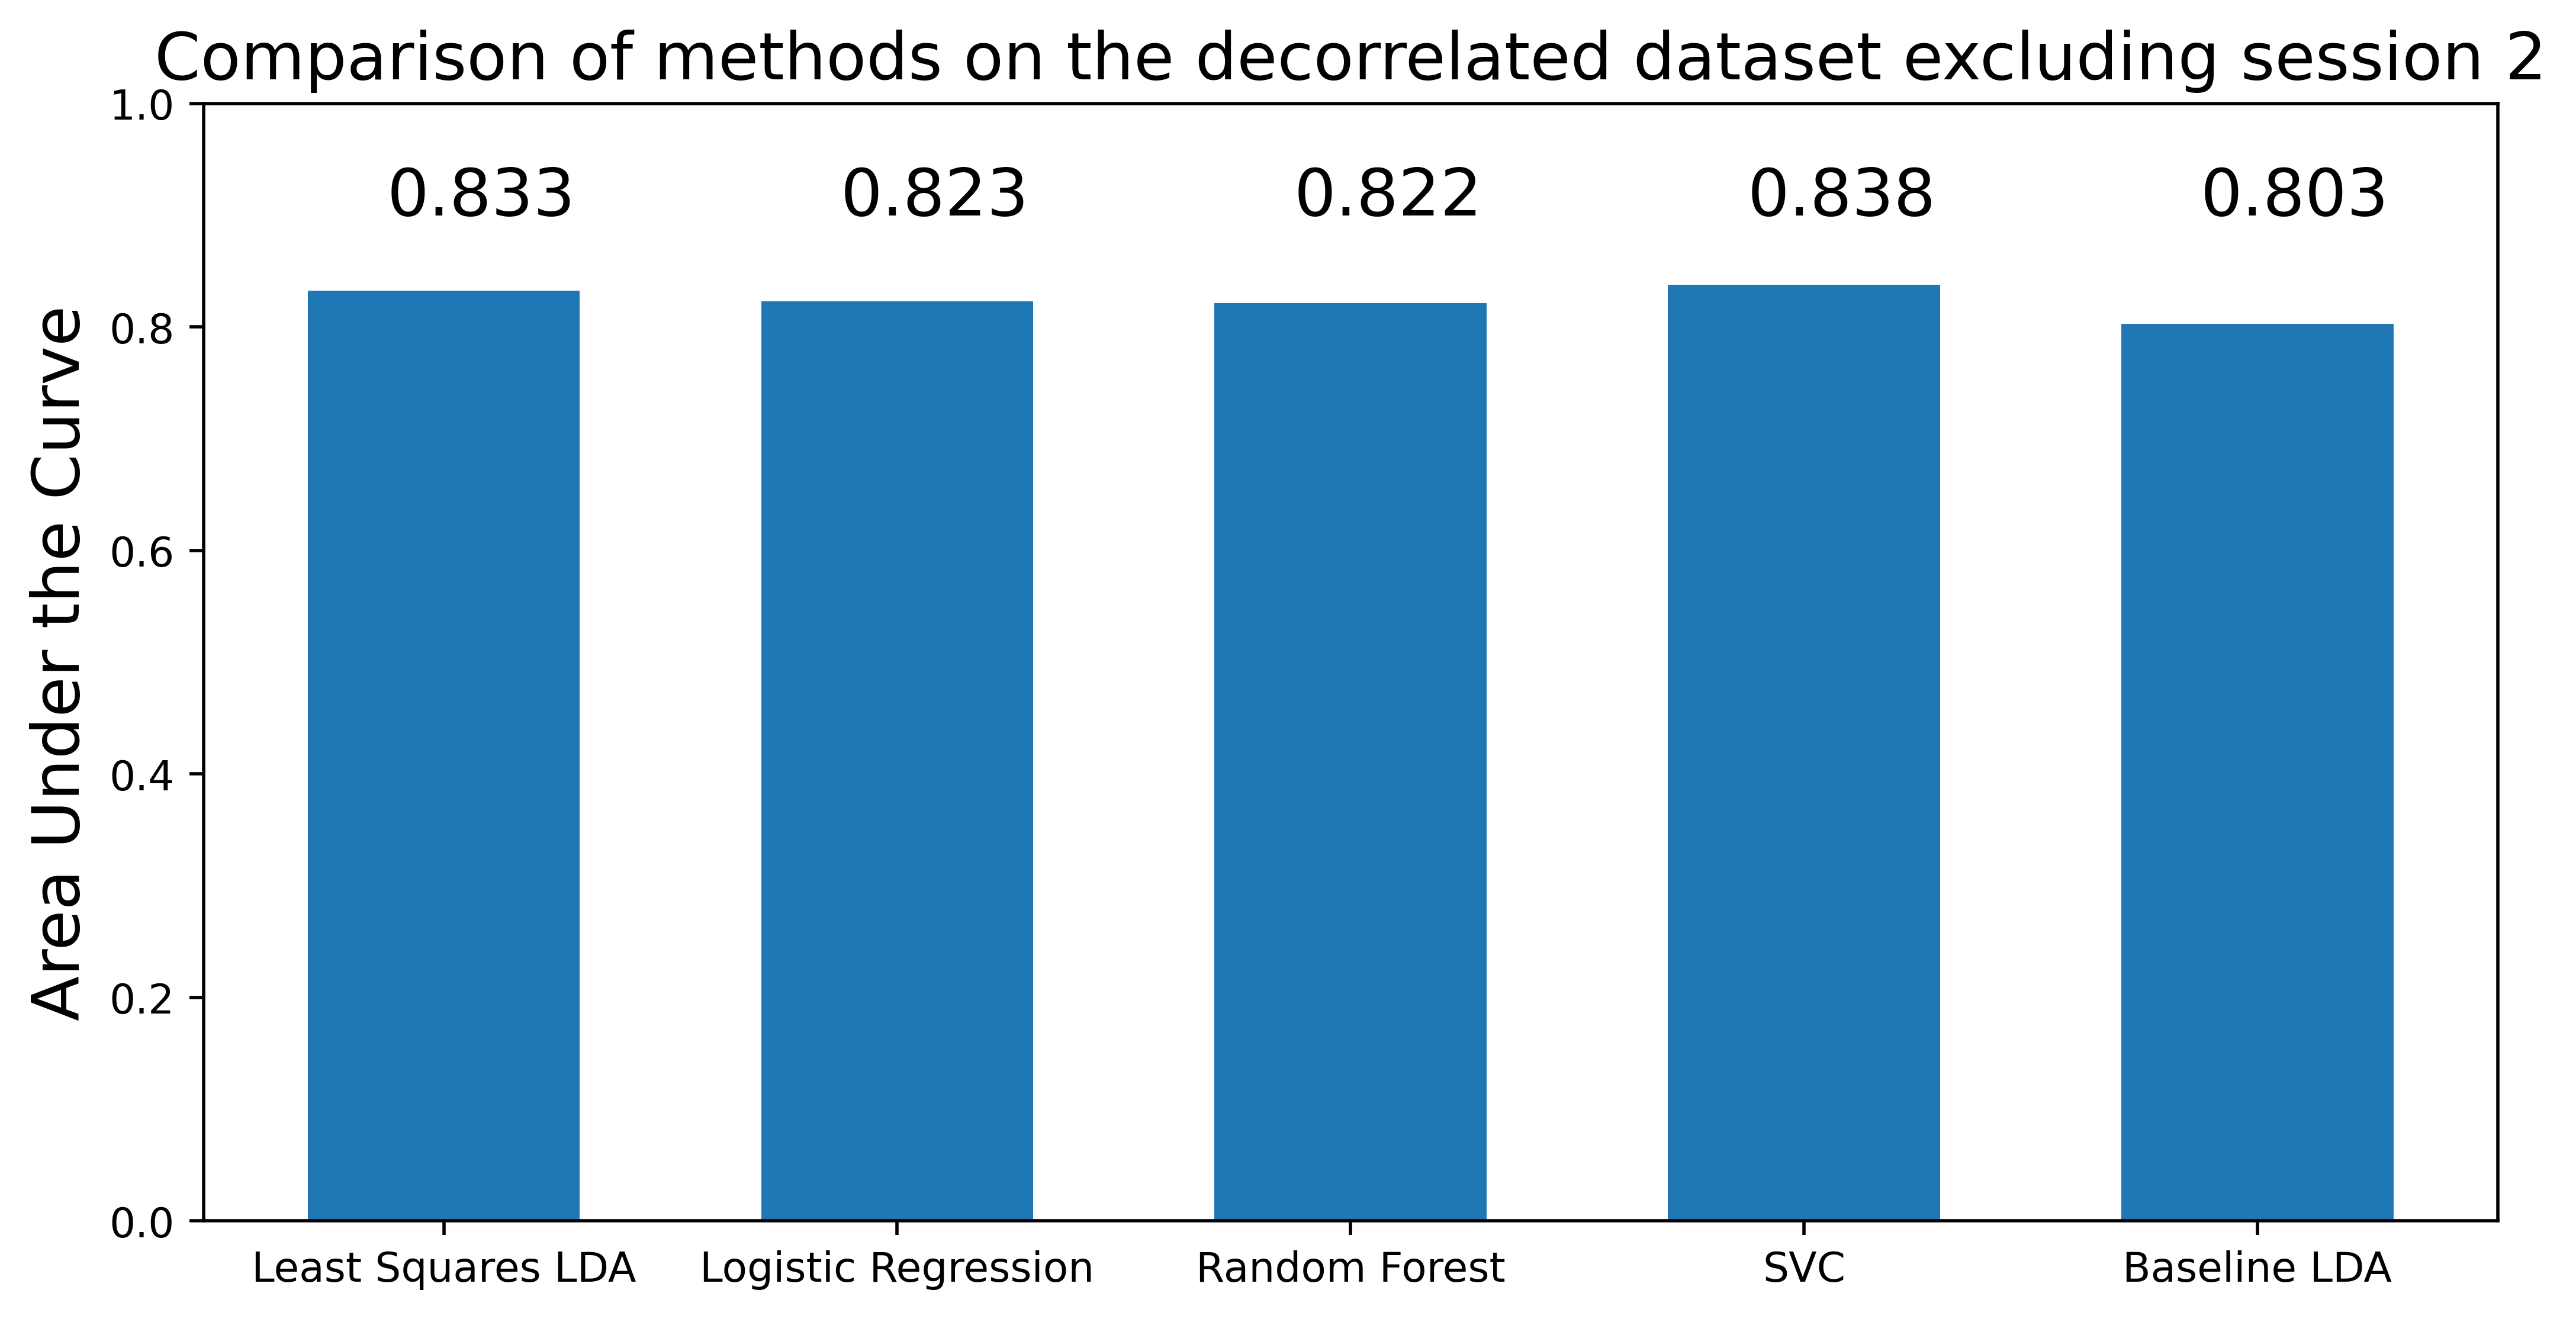

In [3]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 500)
plt.rc('xtick', labelsize=11)
ax.set_ylim(0,1)
ax.bar(standard_holdout_results.rename(columns = {'LDA': 'Least Squares LDA', 
                                                               }).columns[1:6] 
       ,standard_holdout_results.mean()[1:], 0.6)
ax.set_ylabel('Area Under the Curve', fontsize = 16)
for i in range(5):
    ax.text(i - 0.125, 0.9, round(standard_holdout_results.mean()[1:6][i], 3), fontsize = 16)
ax.set_title("Comparison of methods on the decorrelated dataset excluding session 2", fontsize = 16)
plt.show()
fig.savefig('performances/performance comparison decorrelated')

In [98]:
import dill
dill.dump_session('Method_eval_corr.db')